In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Build CNN model using Functional API
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', name='last_conv')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile and train
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, validation_split=0.1)

# Grad-CAM function
def compute_gradcam(model, image, label_index, layer_name='last_conv'):
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        inputs = tf.cast(tf.expand_dims(image, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - accuracy: 0.8913 - loss: 0.3426 - val_accuracy: 0.9797 - val_loss: 0.0699
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9839 - loss: 0.0534 - val_accuracy: 0.9893 - val_loss: 0.0390
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9895 - loss: 0.0345 - val_accuracy: 0.9875 - val_loss: 0.0425
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - accuracy: 0.9918 - loss: 0.0254 - val_accuracy: 0.9913 - val_loss: 0.0332
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accuracy: 0.9898 - val_loss: 0.0337


A new CNN is built using the Keras Functional API and trained on the MNIST digit dataset, this time with max-pooling layers included. The images are first normalised to the range 0–1 and reshaped to (28, 28, 1) to match the expected CNN input format. The model starts with a 32-filter Conv2D layer followed by a MaxPooling2D(2×2) layer to reduce spatial resolution and keep the most important features. This pattern is repeated with 64 filters and another max-pooling layer, and then a final 128-filter Conv2D layer named last_conv, which will be used later for Grad-CAM. The feature maps are flattened and passed through a 64-unit dense layer with ReLU before the final softmax layer outputs class probabilities for the 10 digit classes. The model is compiled with Adam and sparse_categorical_crossentropy, then trained for 5 epochs with a 10% validation split. After training, the compute_gradcam() function is defined to implement Grad-CAM: it builds a secondary model that outputs both the activations of the last_conv layer and the final predictions, computes the gradient of the chosen class score with respect to those feature maps, averages the gradients to get importance weights, and combines them into a heatmap that highlights which regions of the input image most strongly influenced the model’s decision.

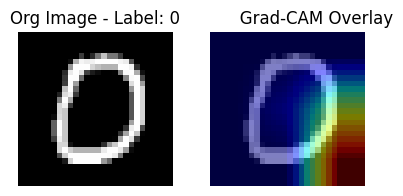

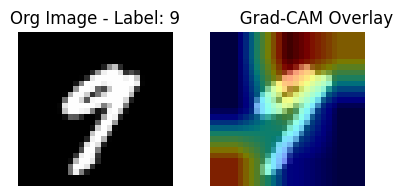

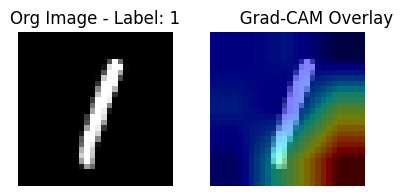

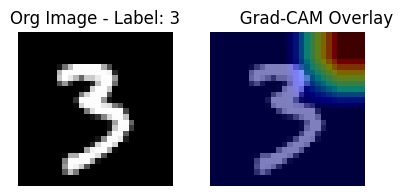

In [3]:
# Visualize Grad-CAM
image_index = [10,20,5,30]
for i in image_index:
  image = X_test[i]
  label = y_test[i]
  heatmap = compute_gradcam(model, image, label)
# Resize heatmap to match input image
  heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [28, 28]).numpy().squeeze()
  plt.figure(figsize=(4, 2))
  plt.subplot(1, 2, 1)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(f"Org Image - Label: {label}")
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
  plt.title("           Grad-CAM Overlay")
  plt.axis('off')
  plt.tight_layout()
  plt.show()

Grad-CAM is applied to a few test images. A list of image indices is chosen, and for each image the true label is retrieved and passed into the compute_gradcam() function. This function returns a heatmap showing which parts of the final convolutional feature maps contributed most to the model’s chosen class. Because the heatmap is smaller than the input image (due to pooling layers), it is resized back to 28×28 so it aligns correctly. For each selected image, two plots are displayed side-by-side: the original grayscale MNIST digit and the same image overlaid with the Grad-CAM heatmap using a ‘jet’ colour map. The highlighted red/yellow areas show which regions of the digit the network relied on most when making its classification.